{/* cspell:ignore prodxz delx delz dely prodxy uparrow downarrow */}

# Exploring uncertainty

For this Qiskit in Classrooms module, students must have a working Python environment with the following packages installed:
- `qiskit` v2.1.0 or newer
- `qiskit-ibm-runtime` v0.40.1 or newer
- `qiskit-aer` v0.17.0 or newer
- `qiskit.visualization`

To set up and install the packages above, see the [Install Qiskit](/docs/guides/install-qiskit) guide.
In order to run jobs on real quantum computers, students will need to set up an account with IBM Quantum&reg; by following the steps in the [Set up your IBM Cloud account](/docs/guides/cloud-setup) guide.

This module was tested and used 8 minutes. of QPU time. This is a good-faith estimate; your actual usage may vary. Two time-consuming calculations are marked as such in header comments and can be carried out on simulators if students are short on QPU time. With those removed, the module requires only ~30 s of QPU time.

Watch the module walkthrough by Dr. Katie McCormick below, or click [here](https://www.youtube.com/watch?v=3h3pwrECbb8&list=PLOFEBzvs-Vvrs2fuvsuT039ariYPsua3d&index=5) to watch it on YouTube.

-------


<IBMVideo id="134413662" title="Katie McCormick introduces quantum uncertainty and tests it on a real quantum computer. Learn which quantities can be simultaneously known, and which ones cannot."/>

## Introduction

You have probably heard of the uncertainty principle, even outside of your physics courses. A common colloquial restatement of uncertainty is "By looking at something, you influence it." That is certainly true. But a more physical way of describing uncertainty is that there are certain physical observables that have an incompatibility that prevents them both from being simultaneously known to arbitrary accuracy. Many students first encounter the pair of incompatible variables $x$ and $p_x$, meaning the position along one axis called the $x$-axis, and the linear momentum along that direction, respectively. For those variables the constraint on uncertainty is written
$$\Delta x \Delta p_x \geq \frac{\hbar}{2}.$$
Here, $\Delta x$ is called the "uncertainty in $x$", which has the same definition as standard deviation in statistics, and can be defined as
$$\Delta x = \sqrt{\langle x^2 \rangle - \langle x \rangle^2}.$$
$\Delta p_x$ is defined in the same way.
Here, we will not derive this uncertainty relation; we will point out that it is consistent with our understanding of classical waves. That is, a wave with truly one perfect frequency $f$ and wavelength $\lambda$ would go on and on forever as a perfect sinusoid. Quantum mechanically, this would correspond to knowing the momentum perfectly according to de Broglie's hypothesis: $\lambda = h/p$. But in order to know $where$ a wave-like particle is located, the wave describing it must become more sharply peaked in space, like a very narrow Gaussian, for example. We know that we can express any continuous function, including such sharply-peaked wave functions, as a Fourier series of sinusoidal functions with different wavelengths. But as the wave function becomes more sharply peaked (and the position is better known), we will require more terms in the Fourier series, meaning a mixture of more wavelengths (and thus, quantum mechanically, more values of momentum).

Stated more simply: a state with a well-defined momentum (a perfect sinusoid in space) has very uncertain position. A state with a well-defined position (like a Dirac delta distribution) has a very uncertain momentum.

There are other variables that exhibit such incompatibility. For example, a particle's spin may have a well-defined projection along one axis, but then we know nothing about the project on an orthogonal axis. For example the state $|0\rangle \sim |\uparrow\rangle$ (for a qubit or spin-1/2 particle) has a definite projection along the $z$ axis (of 1 in the context of a qubit, and of $\hbar/2$ in the context of a spin-1/2 particle). But this state can be written as a superposition of two states each of which has a well-defined projection onto the $x$ axis:
$$|0\rangle = \frac{1}{\sqrt{2}}(|+\rangle_x+|-\rangle_x)$$
or equivalently
$$\begin{pmatrix} 1 \\ 0\end{pmatrix} = \frac{1}{\sqrt{2}}\left[\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1\end{pmatrix}+\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ -1\end{pmatrix}\right].$$
$|+\rangle_x$ has a well-defined projection onto $x$, as does $|-\rangle_x$. So if we specify the projection of a state along the $x$ axis, we do not know the projection along the $z$ axis. And if we specify the projection on the $z$ axis, we don't know the projection along $x$. There are minor differences when discussing this in the context of spin and in qubits. But generally speaking, eigenstates of the Pauli matrices have an interesting relationship that we can explore.
Throughout this lesson, we will be experimentally checking our intuition for the uncertainty in these incompatible variables, and verifying that uncertainty relations hold on IBM quantum computers.

## Simple check of intuition

In this first experiment and throughout the module, we will use a framework for quantum computing known as "Qiskit patterns", which breaks workflows into the following steps:

- Step 1: Map classical inputs to a quantum problem
- Step 2: Optimize problem for quantum execution
- Step 3: Execute using Qiskit Runtime Primitives
- Step 4: Post-processing and classical analysis

We will generally follow these steps, though we may not always explicitly label them.

Let's start by loading some necessary packages including Runtime primitives. We will also select the least-busy quantum computer available to us.

In [1]:
from numpy import pi

# Load the Qiskit Runtime service
from qiskit_ibm_runtime import QiskitRuntimeService

# Syntax for first saving your token
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
# service = QiskitRuntimeService(channel='ibm_quantum_platform')

# Load saved credentials
service = QiskitRuntimeService()

In [2]:
# Load the Runtime primitive and session
from qiskit_ibm_runtime import (
    Batch,
    SamplerV2 as Sampler,
    EstimatorV2 as Estimator,
)

# Use the least busy backend
backend = service.least_busy(min_num_qubits=127)
print(backend.name)

ibm_sherbrooke


If a student exhausts their available quantum computing time during the lesson, the lines below can be un-commented and used to set up a simulator that partly mimics the noise behavior of the quantum computer selected above.

In [3]:
# Import an estimator, this time from qiskit (we will import from Runtime for real hardware)
from qiskit.primitives import BackendSamplerV2
from qiskit.primitives import BackendEstimatorV2

sampler_sim = BackendSamplerV2(backend=backend)
estimator_sim = BackendEstimatorV2(backend=backend)

You might recall that an eigenstate of one operator, Z, is not an eigenstate of another operator X. We will observe that now, experimentally by making measurements along the $x$ and $z$ axes. For the measurement along $z$, we simply use ```qc.measure()```, because IBM quantum computers are structured to measure along $z$. But to measure along $x$, we must rotate the system to effectively move the $x$ axis up to the orientation along which we measure. This is accomplished with a Hadamard gate. There is a similar step required for measurements along $y$. The necessary steps are collected here for convenience:

- To measure along $z$: ```qc.measure()```
- To measure along $x$: ```qc.h()``` then ```qc.measure()```
- To measure along $y$: ```qc.sdg()```, ```qc.h()```, ```qc.s```then ```qc.measure()```

### Step 1: Map classical inputs to a quantum problem

In this case, the mapping step is simply expressing the measurements and rotations descrive above in a quantum circuit:

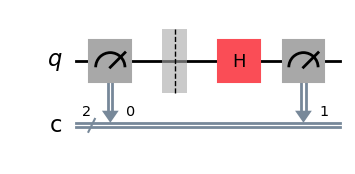

In [4]:
# Step 1: Map

# Import some general packages
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister

# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)

# Add a first measurement
qc.measure(qr, cr[0])
qc.barrier()

# Change basis so that measurements made on quantum computer which normally tell us about z, now tell us about x.
qc.h(qr)

# Add a second measurement
qc.measure(qr, cr[1])

qc.draw("mpl")

### Step 2: Optimize problem for quantum execution

This step takes the operations we want to perform and expresses them in terms of the functionality of a specific quantum computer. It also maps our problem onto the layout of the quantum computer.

In [5]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc)

### Step 3: Execute using Qiskit Runtime primitives

We can use sampler to collect statistics on the measurements. We will construct the Sampler primitive to run on a real quantum computer using ```mode = backend```. There are other modes for other workflows, and we will use one below. Sampler will be used by calling its run() method with a list of "pubs" (Primitive Unified Blocs). Each pub contains up to three values that, together, define a computation unit of work for the estimator to complete: circuits, observables, parameters. You can also provide a list of circuits, a list of observables, and a list of parameters. For more information, read the [Overview of PUBs.](/docs/guides/primitive-input-output#overview-of-pubs)

We want to run on a real quantum computer, so that we are carrying out a real quantum physics experiment. If you exhaust your allotted time on real quantum computers, you can comment out the code below for the quantum computer, and uncomment the code for running on a simulator.

In [6]:
# Step 3: Run the job on a real quantum computer


sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs)
res = job.result()

counts = res[0].data.c.get_counts()

# Run the job on the Aer simulator with noise model from real backend

# job = sampler_sim.run([qc_isa])
# counts=job.result()[0].data.c.get_counts()

### Step 4: Post-processing

This is an especially simple case of post-processing, in which we simply visualize the counts.

Note that Qiskit orders qubits, measurements, and other things by listing the lowest-numbered item last / on the right, a convention referred to as "little-endian". This means that the column below labeled "10" refers to counts where the first measurement yielded a "0", and the second measurements yielded a "1".

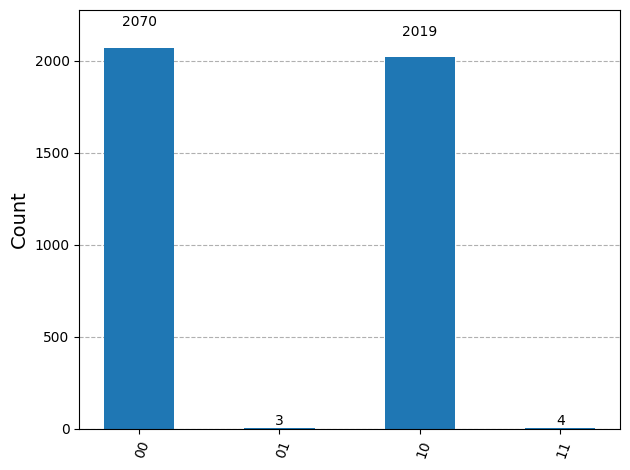

In [7]:
# Step 4: Post-process

from qiskit.visualization import plot_histogram

plot_histogram(counts)

If this convention does not appeal to you, you can use ```marginal_counts``` to visualize the results of each measurement separately:

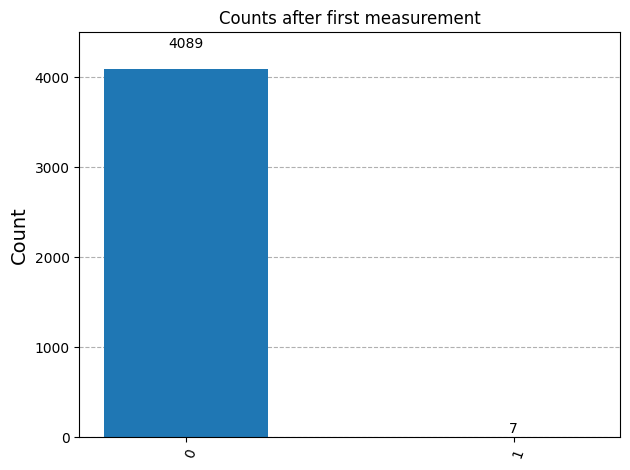

In [8]:
from qiskit.result import marginal_counts

plot_histogram(
    marginal_counts(counts, indices=[0]), title="Counts after first measurement"
)

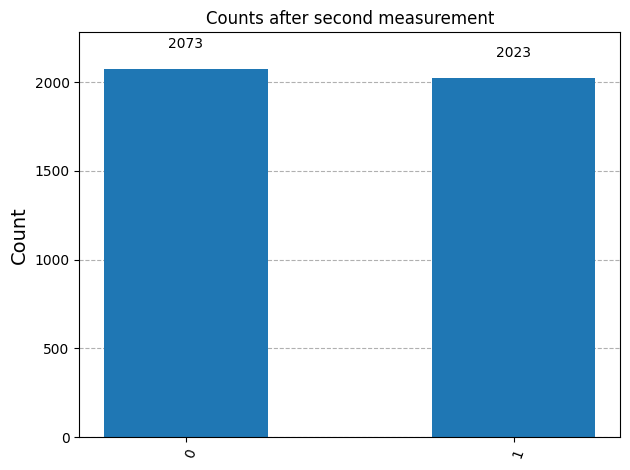

In [9]:
plot_histogram(
    marginal_counts(counts, indices=[1]), title="Counts after second measurement"
)

By default, states in Qiskit are initialized to the $|0\rangle$ state. So it is no surprise that almost all of the first measurements yeilded $|0\rangle$. Note however, that there was almost an even split in the second measurement (the one giving information about projections of the state onto $x$). It seems like this state that gives us a very predictable outcome of measurements along $z$ gives us a very unpredictable set of outcomes for measurements along $x$.
What happens if the make the measurements in the opposite order? We could start by using the Hadamard gate to obtain statistics on the probability of $|0\rangle$ being measured in $|\pm\rangle_x$. Then for the second measurement, we will change back to the $z$ basis using a second Hadamard gate.

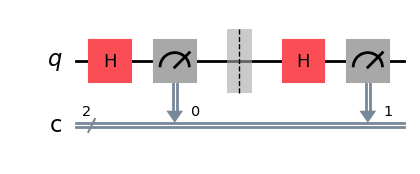

In [10]:
# Step 1:

# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)

# Change basis to measure along x.
qc.h(qr)
qc.measure(qr, cr[0])
qc.barrier()

# Change our basis back to z and make a second measurement
qc.h(qr)
qc.measure(qr, cr[1])

qc.draw("mpl")

In [11]:
# Step 2: Transpile the circuit for running on a quantum computer

pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)

In [12]:
# Step 3: Run the job on a real quantum computer

sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs)
res = job.result()
counts = res[0].data.c.get_counts()

# Run the job on the Aer simulator with noise model from real backend
# job = sampler_sim.run([qc])
# counts = job.result()[0].data.c.get_counts()

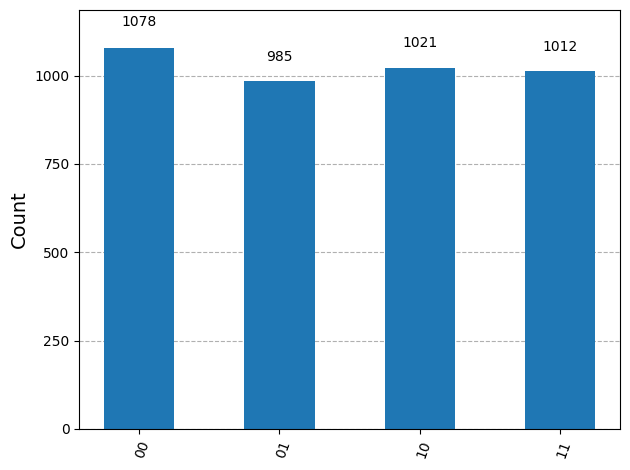

In [13]:
# Step 4: Post-process
from qiskit.visualization import plot_histogram

plot_histogram(counts)

Here, we seem to have even less predictability! Previously, we at least knew what the outcome would be of the first measurement, now we have a fairly even distribution across all possible states. It's not too hard to see why this happened. We started in $|0\rangle$, which is a 50-50 mixture of $|+\rangle_x$ and $|-\rangle_x$, according to
$$|0\rangle=\frac{1}{\sqrt{2}}(|+\rangle_x+|-\rangle_x)$$
So clearly there should be equal probability of obtaining the + or - state (mapped to 0 and 1 in the chart) for the first measurement. The measurement along $x$ collapses the state into either an eigenstate $|+\rangle_x$ or the eigenstate $|-\rangle_x$. Each one of those states is a 50-50 mixture of $|0\rangle$ and $|1\rangle$, according to
$$|+\rangle_x = \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$$
$$|-\rangle_x = \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$$
So once the system is in an eigenstate of $x$, clearly, measurements along $z$ will yield both $|0\rangle$ and $|1\rangle$, and will do so with roughly equal probability.
So our first example showed us that some states will have very predictable outcomes of some measurements, but unpredictable outcomes for other measurements. The current example shows us that we can do worse than that. There are states that can give us unpredictable outcomes for both measurements, even if all we do is swap the order of the measurements. Let's investigate how certain or uncertain a quantity is for a given state.

We can quantify this using uncertainty, or variance. The "uncertainty" is often defined to be the square root of the "variance" of a distribution. That is, the uncertainty for some observable $S$ is denoted $\Delta S$ and is given by

$$
\begin{aligned}
(\Delta S)^2 & \equiv \langle (S - \langle S \rangle)^2 \rangle\\

(\Delta S)^2 & = \langle S^2 - 2 S \langle S \rangle +\langle S \rangle^2 \rangle\\

(\Delta S)^2 & = \langle S^2 \rangle - \langle S \rangle^2
\end{aligned}
$$

For the case of Pauli matrices, for which $S^2 = I$, this becomes

$$
(\Delta S)^2 = 1 - \langle S \rangle^2
$$

Let's apply this to a concrete example. Let's start with the state $|\psi\rangle = |+\rangle_y = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ i \end{pmatrix},$ and let's determine the uncertainty of the observable $X$ in that state.

#### Check your understanding
Read the question below, think about your answer, then click the triangle to reveal the solution.
<details>
<summary>

Calculate the uncertainty of $X$ in the state $|+\rangle_y = |+i\rangle$, by hand.

</summary>

__Answer:__

$$
\Delta X =\sqrt{\langle+i| X^2 |+i\rangle - \langle+i| X |+i\rangle^2}
$$
In the given state, this yields:
$$
\begin{aligned}
\Delta X & =\sqrt{\frac{1}{\sqrt{2}}\begin{pmatrix}1 & -i\end{pmatrix} \begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix} \begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix} \frac{1}{\sqrt{2}}\begin{pmatrix}1 \\ i\end{pmatrix} - \left(\frac{1}{\sqrt{2}}\begin{pmatrix}1 & -i\end{pmatrix} \begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix} \frac{1}{\sqrt{2}}\begin{pmatrix}1 \\ i\end{pmatrix}\right)^2}\\

\Delta X & =\sqrt{\frac{1}{2}\begin{pmatrix}1 & -i\end{pmatrix} \begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix} \begin{pmatrix}1 \\ i\end{pmatrix} - \left(\frac{1}{2}\begin{pmatrix}1 & -i\end{pmatrix} \begin{pmatrix}i \\ 1\end{pmatrix}\right)^2}\\

\Delta X & =\sqrt{\frac{1}{2}\begin{pmatrix}1 & -i\end{pmatrix} \begin{pmatrix}1 \\ i\end{pmatrix} - \left(\frac{1}{2}(0))\right)^2}\\

\Delta X & =\sqrt{\frac{1}{2}(2)} = 1
\end{aligned}
$$

</details>

We can create an arbitrary initial state using ```qc.initialize()```. Note that the syntax for the imaginary unit here is $1j$.

In [14]:
# Step 1: Map the problem into a quantum circuit

from qiskit.quantum_info import SparsePauliOp
import numpy as np

obs = SparsePauliOp("X")

# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)

# Initialize the state
qc.initialize([1, 1j] / np.sqrt(2))

# Step 2: Transpile the circuit

pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs_isa = obs.apply_layout(layout=qc_isa.layout)

# Step 3: Run the circuit on a real quantum computer


estimator = Estimator(mode=backend)
pubs = [(qc_isa, obs_isa)]
job = estimator.run([[qc_isa, obs_isa]])
res = job.result()

# Run the job on the Aer simulator with noise model from real backend
# job = estimator_sim.run([[qc_isa,obs_isa]])
# res=job.result()

# Step 4: Return the result in classical form, and analyze.

print(res[0].data.evs)

-0.02408454165642664


According to our equation above,
$$(\Delta X)^2 = 1 - \langle X \rangle^2 = 1-(0.0015...)^2 \rightarrow \Delta X = 0.999...$$
Let's stick with that same state, but find the expectation value of $Z$, now:

In [15]:
# Step 1: Map the problem into a quantum circuit

obs = SparsePauliOp("Z")

# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)

# Initialize the state to |+>_y
qc.initialize([1, 1j] / np.sqrt(2))


# Step 2: Transpile the circuit

pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs_isa = obs.apply_layout(layout=qc_isa.layout)

# Step 3: Run the circuit on a real quantum computer

estimator = Estimator(mode=backend)
pubs = [(qc_isa, obs_isa)]
job = estimator.run(pubs)
res = job.result()

# Run the job on the Aer simulator with noise model from real backend
# job = estimator_sim.run([[qc_isa,obs_isa]])
# res=job.result()

# Step 4: Return the result in classical form, and analyze.

print(res[0].data.evs)

0.04958271968581247


We could do the same math as before, but we would see that the variance is again very close to 1.0. We could conclude that $\Delta X \Delta Z \approx 1.0$. Indeed this approximately correct for the state we chose. But can we do better? Or worse?

Recall that there is an uncertainty relation between position along one direction, $x,$ and momentum along the same direction, $p_x.$ For those variables, but most familiar form is probably
$$\Delta x \Delta p_x \geq \hbar/2$$
If this is all we remember, we might be tempted to think that $\Delta X$ and $\Delta Z$ could also have such a fundamental limit on uncertainty. Perhaps it is impossible for the product $\Delta X \Delta Z$ to reach zero? Let's try another state and see if this holds. This time, we'll use $|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}.$ Let's see what happens. Note that in the code below, estimator can accept two sets of circuits and observables in the same job submission.

In [16]:
# Step 1: Map the problem into a quantum circuit

obs1 = SparsePauliOp("X")
obs2 = SparsePauliOp("Z")

# Define registers

qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)

# Initialize the state
qc.initialize([1, 1] / np.sqrt(2))

# Step 2: Transpile the circuit

pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs1_isa = obs1.apply_layout(layout=qc_isa.layout)
obs2_isa = obs2.apply_layout(layout=qc_isa.layout)

# Step 3: Run the circuit on a real quantum computer

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    pubs = [(qc_isa, obs1_isa), (qc_isa, obs2_isa)]
    job = estimator.run(pubs)
    res = job.result()
batch.close()

# Run the job on the Aer simulator with noise model from real backend
# job = estimator_sim.run([[qc_isa,obs1_isa],[qc_isa,obs2_isa]])
# res=job.result()

# Step 4: Return the result in classical form, and analyze.

print("The expectation value of the first observable is: ", res[0].data.evs)
print("The expectation value of the first observable is: ", res[1].data.evs)

The expectation value of the first observable is:  1.0011036174126302
The expectation value of the first observable is:  0.0029429797670141016


The expectation value of $X$ should be close to 1.0, but should not exceed 1.0. Don't worry if it exceeds 1.0 by a very small amount. This can be attributed to factors like noise and/or readout error. Although this is a very important topic, we can ignore it for now.

We obtained an expectation value of $X$ that is very close to 1.0 (corresponding to a very low variance for $X$). This makes the product of the two variances quite low:

$$
\Delta X \Delta Z = \sqrt{1-(0.9853)^2} \times \sqrt{1-(-0.00195)^2} = 0.171.
$$

While this is not exactly zero, this value is getting small in comparison with the eigenvalues of the Pauli operators ($\pm 1$). Well, you may recall that the uncertainty relation between linear position and momentum could be written differently, explicitly using the commutation relation between the operators $x$ and $p_x$:

$$
\Delta x \Delta p_x \geq \frac{1}{2}|\langle [x,p_x] \rangle|
$$

where

$$
[x,p_x] = xp_x-p_xx
$$

is the commutator of $x$ and $p_x$.

This is the form that that can be most easily extended to the Pauli operators. Generally, for two operators $A$ and $B$,
$$
\Delta A \Delta B \geq \frac{1}{2}|\langle [A,B] \rangle|.
$$
And in the case of the Pauli matrices $X$ and $Z$, we need $[X,Z]$ in order to calculate
$$
\Delta X \Delta Z \geq \frac{1}{2}|\langle [X,Z] \rangle|.
$$
We show this here, and leave similar calculations to the reader as an exercise:
$$
[X,Z] = XZ-ZX = \begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix}\begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}-\begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}\begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix}
$$
$$
[X,Z] = \begin{pmatrix}0 & -1 \\ 1 & 0\end{pmatrix}-\begin{pmatrix}0 & 1 \\ -1 & 0\end{pmatrix} = 2\begin{pmatrix}0 & -1 \\ 1 & 0\end{pmatrix}
$$
This is a perfectly acceptable answer, but with one more step, we see

$$
[X,Z] = -2i\begin{pmatrix}0 & -i \\ i & 0\end{pmatrix}=-2iY
$$

Our uncertainty relation thus becomes

$$
\Delta X \Delta Z \geq |\langle Y \rangle|.
$$

#### Check your understanding
Read the question below, think about your answer, then click the triangle to reveal the solution.
<details>
<summary>

Determine $[X,Y]$ and $[Y,Z]$. Use this to write down the uncertainty relations between $X$ & $Y$, and $Y$ & $Z$.

</summary>

__Answer:__

$$
[X,Y] = XY-YX = \begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix}\begin{pmatrix}0 & -i \\ i & 0\end{pmatrix}-\begin{pmatrix}0 & -i \\ i & 0\end{pmatrix}\begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix} = 2 \begin{pmatrix}i & 0 \\ 0 & -i\end{pmatrix}=2iZ
$$

$$
[Y,Z] = YZ-ZY = \begin{pmatrix}0 & -i \\ i & 0\end{pmatrix}\begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}-\begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}\begin{pmatrix}0 & -i \\ i & 0\end{pmatrix} = 2 \begin{pmatrix}0 & i \\ i & 0\end{pmatrix}=2iX
$$

Combining with the general uncertainty relation, we have
$$
\Delta X \Delta Y \geq |\langle Z \rangle|,
$$
$$
\Delta Y \Delta Z \geq |\langle X \rangle|.
$$

</details>

### Verify consistency

Before moving on, let us check that this was consistent with our previous finding. We used the state $|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}.$ And we found that $\Delta X \Delta Z  = 0.171.$ Now we know this product should be greater than or equal to
$$
|\langle Y \rangle|=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \end{pmatrix}\begin{pmatrix}0 & -i \\ i & 0\end{pmatrix}\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}
$$
$$
|\langle Y \rangle| = \frac{1}{2}\begin{pmatrix} 1 & 1 \end{pmatrix}\begin{pmatrix} -i \\ i \end{pmatrix} = \frac{1}{2}(-i+i) = 0.
$$

So indeed, $\Delta X \Delta Z  = 0.171 \geq |\langle Y \rangle|=0$

Use the questions below to build some intuition for these findings:


#### Check your understanding
Read the questions below, think about your answers, then click the triangles to reveal the solutions.
<details>
<summary>

Answer the following items together as a set:

(a) What states would you expect to have zero uncertainty in $X$?

(b) What states would you expect to have zero uncertainty in $Z$?

(c) In what states would you obtain a zero expectation value $\langle Y \rangle$?

(d) Are the answers to the above questions consistent with the case $\Delta X \Delta Z \geq |\langle Y \rangle|$?

(e) Write code to explicitly check this using estimator.

</summary>

__Answers:__

(a) We might expect eigenstates of the $X$ operator to yield zero uncertainty in $X$. Indeed, using $|\psi\rangle = |+\rangle_x,$ we have
$$\Delta X = \sqrt{1-\langle X \rangle^2} = \sqrt{1-1^2} = 0.$$

(b) We might expect eigenstates of the $Z$ operator to yield zero uncertainty in $Z$. Indeed, using $|\psi\rangle = |1\rangle,$ we have
$$\Delta Z = \sqrt{1-\langle Z \rangle^2} = \sqrt{1-(-1)^2} = 0.$$

(c) We expect to find $\langle Y \rangle=0$ for any states that, when measured, yield a positive projection on the $y$ axis just as often as a negative projection. These include the eigenstates of $X$ and $Z$.

(d) Yes. One would expect a very small value for the product of uncertainties $\Delta X \Delta Z $ for eigenstates of $X$ or $Z$: $\Delta X \Delta Z \approx 0.$ This can hold because we would also expect $\langle Y \rangle=0$ for those same states. So the uncertainty relation could be satisfied.

(e) Code such as the following would verify this:
```
obs1 = SparsePauliOp.from_list(
    [("X", 1.000)]
)
obs2 = SparsePauliOp.from_list(
    [("Y", 1.000)]
)
obs3 = SparsePauliOp.from_list(
    [("Z", 1.000)]
)
qc = QuantumCircuit(1,1)
qc.ry(pi/2,0)

job = estimator.run([(qc, [[obs1], [obs2], [obs3]])], precision=0.001)
res=job.result()
```
Where the results returns all expectation values. To retrieve all expectation values and calculate uncertainties, we could use:
```
xs=res[0].data.evs[0]
ys=abs(res[0].data.evs[1])
zs=res[0].data.evs[2]

import math
prodxz=((1-xs[i]*xs[i])**0.5)*(1-zs[i]*zs[i])**0.5

```
</details>


<details>
<summary>

Answer the following items together as a set:

(a) Can you think of a state in which you would have a large expectation value $\langle Y \rangle$?

(b) Would you expect that same state to have large or small uncertainty in $X$?

(c) Would you expect that same state to have large or small uncertainty in $Z$?

(d) Are the answers to the above questions consistent with the case $\Delta X \Delta Z \geq |\langle Y \rangle|$?

(e) Write code to explicitly check this using estimator.

</summary>

__Answers:__

(a) We expect to find $\langle Y \rangle\approx 1$ for the eigenstate of $Y$: $|+\rangle_y$.

(b) We might expect $X$ to have large uncertainty in the state $|+\rangle_y,$ since measuring $X$ in that state would yield a positive and negative result with equal frequency/probability.

(c) We might expect $Z$ to have large uncertainty in the state $|+\rangle_y,$ since measuring $Z$ in that state would yield a positive and negative result with equal frequency/probability.

(d) Yes. One would expect a large value for the product of uncertainties $\Delta X \Delta Z $ for eigenstates of $Y,$ and for $|+\rangle_y,$ specifically. We would also expect $\langle Y \rangle\approx 1$ for that same state. So both $\langle Y \rangle$ and $\Delta X \Delta Z $ are both fairly large in this state, and it is plausible that the uncertainty relation could again be satisfied.

(e) Code such as the following would verify this:
```
obs1 = SparsePauliOp.from_list(
    [("X", 1.000)]
)
obs2 = SparsePauliOp.from_list(
    [("Y", 1.000)]
)
obs3 = SparsePauliOp.from_list(
    [("Z", 1.000)]
)
qc = QuantumCircuit(1,1)
qc.rx(-pi/2,0)

job = estimator.run([(qc, [[obs1], [obs2], [obs3]])], precision=0.001)
res=job.result()
```
Where the results returns all expectation values. To retrieve all expectation values and calculate uncertainties, we could use:
```
xs=res[0].data.evs[0]
ys=abs(res[0].data.evs[1])
zs=res[0].data.evs[2]

import math
prodxz=((1-xs[i]*xs[i])**0.5)*(1-zs[i]*zs[i])**0.5

```
</details>

The test above only demonstrated the validity of the uncertainty relation for a single choice of state vector $|\psi\rangle = |+\rangle_x$. To convince ourselves that this is generally consistent with experiment, we should carry out similar calculations using estimator for many choices of the state vector. Let's start by rotating our state vector away from the $z$ axis, using an ```RY``` gate to produce different initial states using a parameter $\theta$.

In [ ]:
# The calculation below uses approximately 3-4 minutes of QPU time.
# Step 1: Map the problem into a quantum circuit

from qiskit.circuit import Parameter
import numpy as np

# Specify observables
obs1 = SparsePauliOp("X")
obs2 = SparsePauliOp("Y")
obs3 = SparsePauliOp("Z")

# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)

# Rotate away from |0>
theta = Parameter("θ")
qc.ry(theta, 0)

params = np.linspace(0, 2, num=21)

# Step 2: Transpile the circuit

pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs1_isa = obs1.apply_layout(layout=qc_isa.layout)
obs2_isa = obs2.apply_layout(layout=qc_isa.layout)
obs3_isa = obs3.apply_layout(layout=qc_isa.layout)

# Step 3: Run the circuit on a real quantum computer

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    pubs = [(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])]
    job = estimator.run(pubs, precision=0.01)
    res = job.result()

batch.close()

# Run the job on the Aer simulator with noise model from real backend
# job = estimator_sim.run([(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])], precision=0.01)
# res=job.result()

In [18]:
# Step 4: Post-processing and classical analysis.
xs = res[0].data.evs[0]
ys = abs(res[0].data.evs[1])
zs = res[0].data.evs[2]

# Calculate uncertainties

delx = []
delz = []
prodxz = []
for i in range(len(xs)):
    delx.append(abs((1 - xs[i] * xs[i])) ** 0.5)
    delz.append(abs((1 - zs[i] * zs[i])) ** 0.5)
    prodxz.append(delx[i] * delz[i])

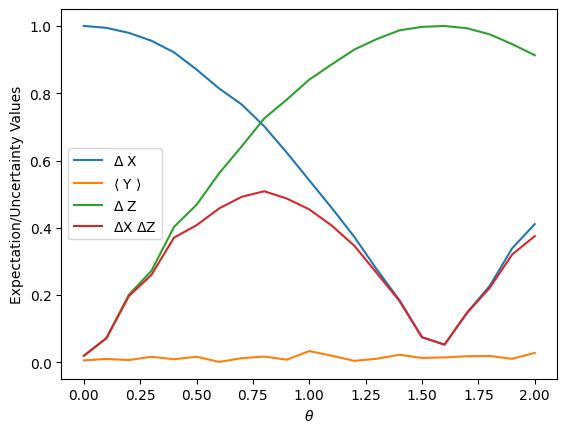

In [19]:
# Here we can plot the results from this simulation.
import matplotlib.pyplot as plt

plt.plot(params, delx, label=r"$\Delta$ X")
plt.plot(params, ys, label=r"$\langle$ Y $\rangle$")
plt.plot(params, delz, label=r"$\Delta$ Z")
plt.plot(params, prodxz, label=r"$\Delta$X $\Delta$Z")
plt.xlabel(r"$\theta$")
plt.ylabel("Expectation/Uncertainty Values")
plt.legend()
plt.show()

Note that the red curve $(\Delta X \Delta Z)$ is always greater than the orange curve $\langle Y \rangle.$ Sometimes the uncertainty product dips and is somewhat close to the limit, and other times it rises and is farther from the limit, but it always obeys the uncertainty relation.

Of course, this might not be the best test of the uncertainty relation, since our limit $\langle Y \rangle$ is always very close to zero. Let's use a quantum state that has a larger projection on eigenstates of $Y$. Specifically, we will still rotate rotate $|0\rangle$ down from the $z$ axis by varying angles, but now we will also rotate that resulting state around $z$ by some angle, perhaps $\pi/4$, and see what happens.

In [ ]:
# The calculation below uses approximately 3-4 minutes of QPU time.
from qiskit.circuit import Parameter
import numpy as np

# Step 1: Map the problem to a quantum circuit

# Specify observables
obs1 = SparsePauliOp("X")
obs2 = SparsePauliOp("Y")
obs3 = SparsePauliOp("Z")

# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)

# Rotate away from |0> along one plane, and then along a transverse direction.
theta = Parameter("θ")
qc.ry(theta, 0)
qc.rz(pi / 4, 0)

params = np.linspace(0, 2, num=21)

# Step 2: Transpile the circuit

pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)

obs1_isa = obs1.apply_layout(layout=qc_isa.layout)
obs2_isa = obs2.apply_layout(layout=qc_isa.layout)
obs3_isa = obs3.apply_layout(layout=qc_isa.layout)

# Step 3: Run the circuit on a real quantum computer

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    pubs = [(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])]
    job = estimator.run(pubs, precision=0.01)
    res = job.result()

batch.close()

# Run the job on the Aer simulator with noise model from real backend
# job = estimator_sim.run([(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])], precision=0.01)
# res=job.result()

In [21]:
# Step 4: Post-processing and classical analysis.
xs = res[0].data.evs[0]
ys = abs(res[0].data.evs[1])
zs = res[0].data.evs[2]

# Calculate uncertainties

delx = []
delz = []
prodxz = []
for i in range(len(xs)):
    delx.append(abs((1 - xs[i] * xs[i])) ** 0.5)
    delz.append(abs((1 - zs[i] * zs[i])) ** 0.5)
    prodxz.append(delx[i] * delz[i])

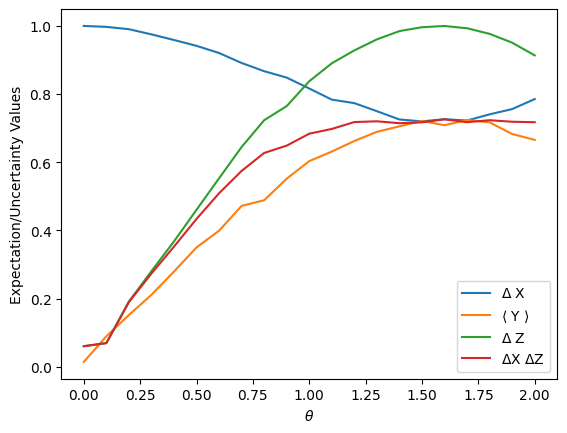

In [22]:
# Here we can plot the results from this simulation.
import matplotlib.pyplot as plt

plt.plot(params, delx, label=r"$\Delta$ X")
plt.plot(params, ys, label=r"$\langle$ Y $\rangle$")
plt.plot(params, delz, label=r"$\Delta$ Z")
plt.plot(params, prodxz, label=r"$\Delta$X $\Delta$Z")
plt.xlabel(r"$\theta$")
plt.ylabel("Expectation/Uncertainty Values")
plt.legend()
plt.show()

Now we see that the limit on the uncertainty $(\Delta X \Delta Z)$ is being put to the test! The red curve comes much closer to the orange curve than before. In fact, in the absence of noise, the uncertainty relation would be exactly saturated ($(\Delta X \Delta Z) = \langle Y \rangle$) one point. In the presence of noise and readout error, it should not be surprising if a run occassionally yields $(\Delta X \Delta Z)$ very slightly larger than $\langle Y \rangle.$ This is not a true violation of uncertainty; it is just an artifact of non-zero error.

#### Check your understanding
Read the questions below, think about your answers, then click the triangles to reveal the solutions.
<details>
<summary>

Explain how you would push this to the absolute limit, making $\langle Y \rangle$ as large as possible?

</summary>

__Answer:__

The code currently has lines that rotate the default initial state $|0\rangle$, down from the $z$ axis by some parametrized angle $\theta$ and then also around the $z$ axis by an angle $\pi/4,$ which rotates the state vector part of the way over to the $y$ axis.

`qc.ry(theta,0)`

`qc.rz(pi/4,0)`

We could change the rotation about $z$ from $\pi/4$ to $\pi/2$, rotating all the way to an eigenstate of $Y$:

`qc.ry(theta,0)`

`qc.rz(pi/2,0)`

No other changes would be required.

</details>

<details>
<summary>

Change the code or copy it over and implement that check of the uncertainty relation with the expectation value of Y maximized. Does the uncertainty relation hold?

</summary>

__Answer:__

We would use exactly the code from the example above, with

`qc.rz(pi/2,0)`

swapped in to replace

`qc.rz(pi/4,0).`

 The resulting figure should look like that below, and yes, the uncertainty principle should still be valid.

 ![A plot comparing uncertainty to the maximum expectation value of the Y operator.](/learning/images/modules/quantum-mechanics/exploring-uncertainty-with-qiskit/checkin.avif)

</details>

<details>
<summary>

Modify the code above to make a similar picture, demonstrating that from measurements on the quantum computer the product $\Delta X \Delta Y$ behaves as it should. Choose any set of states you like.

</summary>

__Answer:__

We would use exactly the code from the example above, and in face we could use the same results from above, just using the expectation values to calculate different uncertainties. For example, we could use

```
xs=res[0].data.evs[0]
ys=res[0].data.evs[1]
zs=abs(res[0].data.evs[2])
import math
delx = []
dely = []
prodxy=[]
for i in range(len(xs)):
    delx.append((1-xs[i]*xs[i])**0.5)
    dely.append((1-ys[i]*ys[i])**0.5)
    prodxy.append(((1-xs[i]*xs[i])**0.5)*(1-ys[i]*ys[i])**0.5)
```

and we could plot

```
import matplotlib.pyplot as plt
plt.plot(params, delx, label=r'$\Delta$ X')
plt.plot(params, dely, label=r'$\langle$ Y $\rangle$')
plt.plot(params, zs, label=r'$\Delta$ Z')
plt.plot(params, prodxy, label=r'$\Delta$X $\Delta$Z')
plt.xlabel(r'$\theta$')
plt.ylabel('Expectation/Uncertainty Values')
plt.legend()
plt.show()
```

</details>

Challenge: Write code to scan through many values of $\phi$, just as we scanned through many values of $\theta$, and make a 3-D plot showing that the uncertainty relation is never violated. Pick any observables you like.

### Critical concepts:

- There are uncertainty relations between many sets of physical observables, including position & linear momentum, and components of spin.
- The Pauli matrices do not commute. This is a mathematical reflection of the fact that not all components of spin can be simultaneously known/determined.
- Quantum computing makes heavy use of the Pauli operators/matrices, so it is useful to know the uncertainty relation for Pauli operators, as well as the closely-related spin operators.
- A general formula for the uncertainty of two operators $A$ and $B$ is $$\Delta A \Delta B \geq \frac{1}{2}|\langle [A,B] \rangle|.$$
- An eigenstate $|a\rangle$ of some operator $A$ yields zero uncertainty in the physical observable associated with that operator. Even experimentally, $\langle a|A|a\rangle \approx 0.$
- An eigenstate $|a\rangle$ of some operator $A$ will yield a larger uncertainty for an operator $B$ that does not commute with $A$.
- Experimental results using a real quantum computer confirm the intuition we gain from matrix representations of physical operators.


## Questions

### T/F Questions:

1. T/F One can simultaneously measure $X$ and $Y$, but not $Z$.
2. T/F One can simultaneously measure $X$ and $Z$, but not $Y$.
3. T/F Linear position and linear momentum operators do not commute.
4. T/F IBM quantum computers measure along $Z$ by default, so a rotation must be performed to measure along any other direction.
5. T/F The circuit below effectively measures $Z$ and then $X$.

![A circuit diagram showing a measurement, a Hadamard gate, and then another measurement.](/learning/images/modules/quantum-mechanics/exploring-uncertainty-with-qiskit/tf-q5.avif)

### MC Questions:

1. The diagram below demonstrates which of the following uncertainty relations?

    - a. $\Delta X \Delta Y \geq |\langle Z \rangle|$
    - b. $\Delta Y \Delta Z \geq |\langle X \rangle|$
    - c. $\Delta Z \Delta X \geq |\langle Y \rangle|$
    - d. None of the above

![A plot comparing uncertainty to the maximum expectation value of the Y operator.](/learning/images/modules/quantum-mechanics/exploring-uncertainty-with-qiskit/checkin.avif)

2. Which of the following is the standard sequence to perform a measurement along $x$?
    - a. Only ```qc.measure()```
    - b. ```qc.h()``` then ```qc.measure()```
    - c. ```qc.h()```, ```qc.h()``` then ```qc.measure()```
    - d. ```qc.h()```, ```qc.s```, ```qc.h()```then ```qc.measure()```
    - e. ```qc.sdg()```, ```qc.h()```, ```qc.s``` then ```qc.measure()```
    - f. ```qc.sdg()```, ```qc.h()```, ```qc.s```, ```qc.h()``` then ```qc.measure()```

3. Which of the following states yields the largest expectation value $\langle X \rangle$?
    - a. $|+\rangle_x$
    - b. $|-\rangle_x$
    - c. $|+\rangle_y$ also called $|+i\rangle$
    - d. $|-\rangle_y$ also called $|-i\rangle$
    - e. $|0\rangle$ also called $|\uparrow\rangle$
    - f. $|1\rangle$ also called $|\downarrow\rangle$

4. Which of the following states yields the largest uncertainty $\Delta X$?
    - a. $|+\rangle_x$
    - b. $|+\rangle_y$ also called $|+i\rangle$
    - c. $|0\rangle$ also called $|\uparrow\rangle$
    - d. a and b are tied
    - e. b and c are tied
    - f. a, b, and c are tied



### Discussion Questions:

1. Does this concept of uncertainty conflict in any way with the notion of spin as a vector arrow in Cartesian space? How about on the Bloch sphere?

2. Suppose you orient a measurement device along a direction half-way between the $x$ and $y$ axes. What happens? Can you make a measurement along this direction? How does this relate to uncertainty in $X$ and $Y$?

3. What additional experiments would you like to do to convince yourself of the results obtained here?